<a href="https://colab.research.google.com/github/ayushiitbhu2800/Medium-Term-Load-Forecasting/blob/main/Medium_Term_Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 125

In [ ]:
! git clone https://github.com/ayushiitbhu2800/Medium-Term-Load-Forecasting;

Cloning into 'Medium-Term-Load-Forecasting'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [ ]:
df = pd.read_csv("/content/Medium-Term-Load-Forecasting/full_dataset.csv")
df["date"] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

df["date"] = pd.to_datetime(df["date"])
df = df.rename(columns={"date" : "time"})
df = df.set_index("time")

df["weekday"] = df["weekday"].apply(lambda x : 1 if x < 6 else 0)
df = df.drop(columns=['year', 'month', 'day', 'hour'])
df = df.rename(columns={"demand" : "load"})
df.head()

,weekday,load,temperature,humd
time,,,,
2004-01-01 00:00:00,1,14703,1.4,59.0
2004-01-01 01:00:00,1,14130,1.4,64.0
2004-01-01 02:00:00,1,13575,1.6,65.0
2004-01-01 03:00:00,1,13280,2.0,64.0
2004-01-01 04:00:00,1,13219,2.0,65.0


In [ ]:
df.tail()

,weekday,load,temperature,humd
time,,,,
2019-12-31 19:00:00,1,15909,0.7,68.0
2019-12-31 20:00:00,1,15198,0.4,69.0
2019-12-31 21:00:00,1,14678,0.2,68.0
2019-12-31 22:00:00,1,14136,-0.1,69.0
2019-12-31 23:00:00,1,13578,-0.2,72.0


Text(0, 0.5, 'Electricity Demand [MW]')

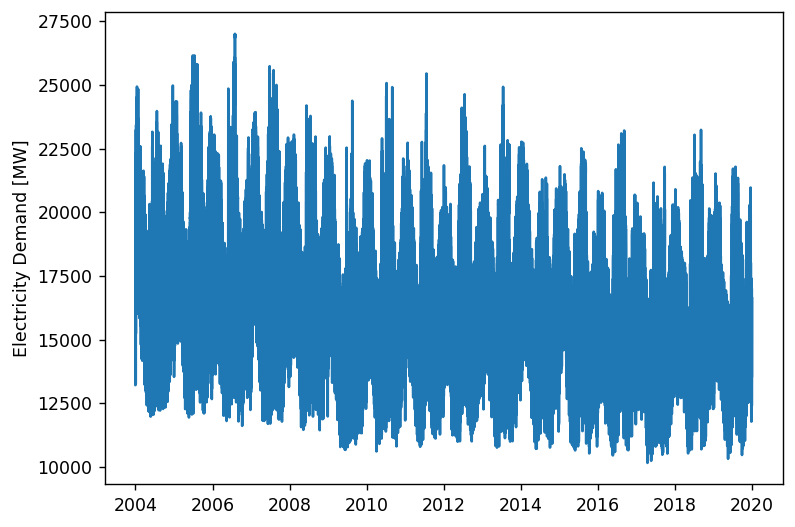

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 125
plt.plot(df['load'])
plt.ylabel('Electricity Demand [MW]')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2004-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   weekday      140256 non-null  int64  
 1   load         140256 non-null  int64  
 2   temperature  139422 non-null  float64
 3   humd         139423 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 5.4 MB


In [ ]:
df["temperature"] = df["temperature"].bfill()
df["temperature"] = ((df["temperature"]*9)/5) + 32
df = df.rename(columns={"temperature" : "temp"})
df["humd"] = df['humd'].bfill()
df["humd"] = df['humd']/100.

df['sin_hour'] = np.sin(2*np.pi*df.index.hour.values/24)
df['cos_hour'] = np.cos(2*np.pi*df.index.hour.values/24)

In [ ]:
df.head()

,weekday,load,temp,humd,sin_hour,cos_hour
time,,,,,,
2004-01-01 00:00:00,1,14703,34.52,0.59,0.000000,1.000000
2004-01-01 01:00:00,1,14130,34.52,0.64,0.258819,0.965926
2004-01-01 02:00:00,1,13575,34.88,0.65,0.500000,0.866025
2004-01-01 03:00:00,1,13280,35.60,0.64,0.707107,0.707107
2004-01-01 04:00:00,1,13219,35.60,0.65,0.866025,0.500000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2004-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   weekday   140256 non-null  int64  
 1   load      140256 non-null  int64  
 2   temp      140256 non-null  float64
 3   humd      140256 non-null  float64
 4   sin_hour  140256 non-null  float64
 5   cos_hour  140256 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 7.5 MB


In [ ]:
df_norm = df.copy()

load_min, load_max = df['load'].min(), df['load'].max()
temp_min, temp_max = df['temp'].min(), df['temp'].max()

df_norm['load'] = (df['load'] - load_min) / (load_max - load_min)
df_norm['temp'] = (df['temp'] - temp_min) / (temp_max - temp_min)

df_norm.head()

,weekday,load,temp,humd,sin_hour,cos_hour
time,,,,,,
2004-01-01 00:00:00,1,0.269391,0.423077,0.59,0.000000,1.000000
2004-01-01 01:00:00,1,0.235360,0.423077,0.64,0.258819,0.965926
2004-01-01 02:00:00,1,0.202399,0.426282,0.65,0.500000,0.866025
2004-01-01 03:00:00,1,0.184879,0.432692,0.64,0.707107,0.707107
2004-01-01 04:00:00,1,0.181257,0.432692,0.65,0.866025,0.500000


# **SARIMA: Monthly Means Model**

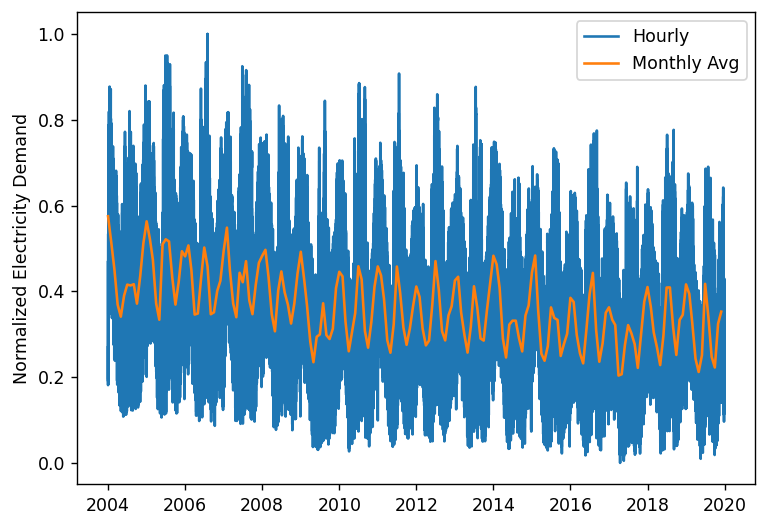

In [ ]:
monthly_norm = df_norm['load'].resample('MS').mean().bfill()
plt.plot(df_norm['load'], label='Hourly')
plt.plot(monthly_norm, label='Monthly Avg')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

In [ ]:
train = monthly_norm[:'2016']
validate = monthly_norm['2017':'2018']
test = monthly_norm['2019':]

In [ ]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# train SARIMA model and get validation set performance
def get_sarima_mae(y_tr, hp, y_te):
    try:
        model = SARIMAX(y_tr, order=(hp[0],hp[1],hp[2]), seasonal_order=(hp[3],hp[4],hp[5],12)).fit()
        y_hat = model.get_forecast(steps=len(y_te)).predicted_mean
        return np.mean(np.abs(y_hat - y_te))
    except:
        return None

# define potential SARIMA hyerparameters
p = d = q = P = D = Q = range(2)
hp_list = list(product(p,d,q,P,D,Q))
grid_search = pd.DataFrame(columns=['p','d','q','P','D','Q','mae'])

# perform grid search
for i, hp in enumerate(hp_list):
    mae = get_sarima_mae(train, hp, validate)
    if mae != None:
        params = {'p':hp[0], 'd':hp[1], 'q':hp[2], 'P':hp[3], 'D':hp[4], 'Q':hp[5], 'mae':mae}
        grid_search = grid_search.append(params, ignore_index=True)

# display best performing hyperparamters
grid_search.sort_values('mae').head(1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,p,d,q,P,D,Q,mae
44,1.0,0.0,1.0,1.0,0.0,1.0,0.027859


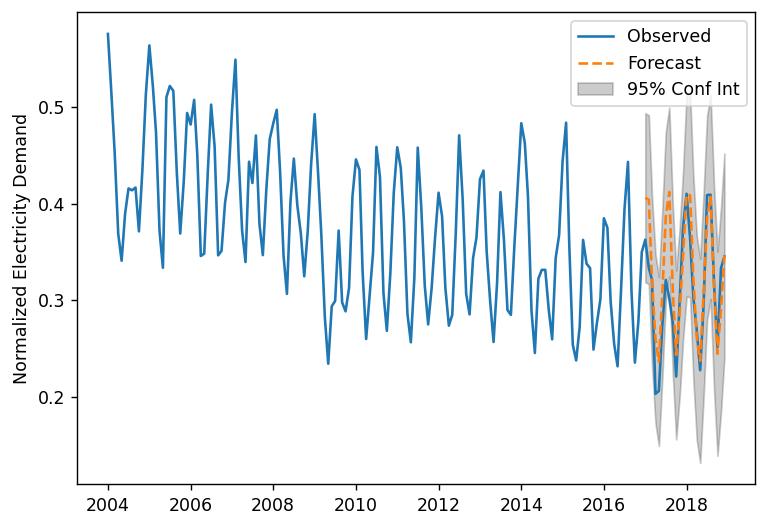

In [ ]:
# best hyperparameters from grid search
best_monthly_order = (0,0,0)
best_monthly_seas_order = (1,1,1,12)

# fit SARIMA model
model_m = SARIMAX(train, order=best_monthly_order, seasonal_order=best_monthly_seas_order).fit()

# get forecast and confidence interval for forecast
forecast = model_m.get_forecast(steps=len(validate))
pred = pd.Series(forecast.predicted_mean, index=validate.index)
ci = forecast.conf_int(alpha=0.05)

# plotting
plt.plot(monthly_norm[:'2018'], label='Observed')
plt.plot(pred, label='Forecast', ls='--')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1],
                 color='k', alpha=0.2, label='95% Conf Int')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

# **Regression: Hourly Residuals Model**

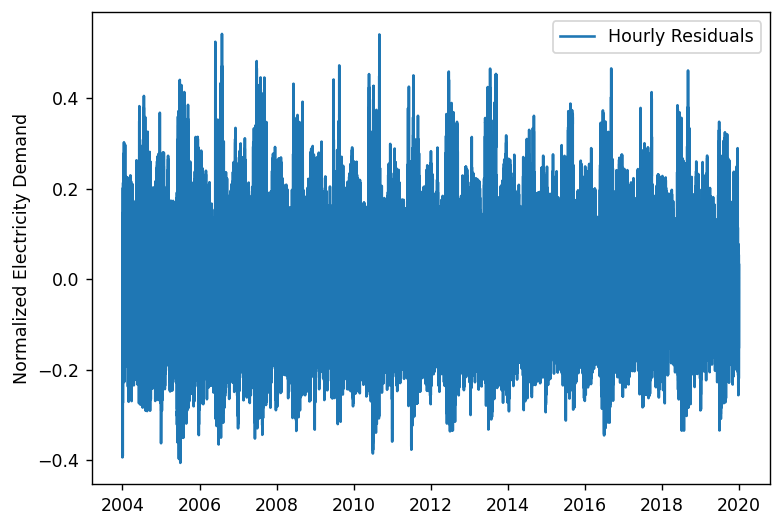

In [ ]:
hourly_res_norm = df_norm.copy()
hourly_res_norm['load'] = df_norm['load'].groupby(pd.Grouper(freq='M')).transform(lambda x: x - x.mean())
plt.plot(hourly_res_norm['load'], label='Hourly Residuals')
plt.ylabel('Normalized Electricity Demand')
plt.legend();

In [ ]:
# train-validate-test split
train = hourly_res_norm[:'2016']
validate = hourly_res_norm['2017':'2018']
test = hourly_res_norm['2019':]

# setup training variables 
exog_tr = train.iloc[:,1:].values
ar_tr = train['load'].shift().bfill().values[:,None]
X_tr = np.hstack([ar_tr, exog_tr])
y_tr = train['load'].values

# setup validation variables
exog_val = validate.iloc[:,1:].values
y_val = validate['load'].values

# setup testing variables
exog_te = test.iloc[:,1:].values

# setup miscellaneous variables
yp_full = hourly_res_norm.loc[:'2018','load']
yp_val = hourly_res_norm.loc['2017':'2018','load']
yp_te = hourly_res_norm.loc['2019':,'load']
y_init_val = np.hstack([y_tr[-1], validate.iloc[167::168,0].values])
y_init_te = np.hstack([y_val[-1], test.iloc[167::168,0].values])

In [ ]:
def compute_mae(y, yhat):
    """given predicted and observed values, computes mean absolute error"""
    return np.mean(np.abs(yhat - y))

def forecast(model, exog, y_init):
    """given a trained model, exogenous features, and initial AR term, makes forecasting predictions"""
    yhat = []
    Xi_te = np.hstack([y_init, exog[0]])[None,:]
    for i in range(len(exog)-1):
        yhat_i = model.predict(Xi_te)[0]
        yhat.append(yhat_i)
        Xi_te = np.hstack([yhat_i, exog[i+1]])[None,:]
    yhat.append(model.predict(Xi_te)[0])
    return np.array(yhat)

def weekly_forecast(model, exog, y_init):
    """given a trained model exogenous features, and initial AR term, makes a series of 1-week-out forecasts"""
    yhat = []
    for i, yi in enumerate(y_init):
        exog_i = exog[168*i:168*(i+1),:]
        if exog_i.shape[0] < 1:
            break
        yhat.append(forecast(model, exog_i, yi))
    return np.hstack(yhat)

def plot_full(y, yhat, yhat_idx):
    """plots observed and forecasted values for the full date range"""
    pred = pd.Series(yhat, index=yhat_idx)
    plt.figure()
    plt.plot(y, label='Observed')
    plt.plot(pred, label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    
def plot_week(y, yhat, yhat_idx):
    """plots observed and forecasted values for one week span"""
    pred = pd.Series(yhat, index=yhat_idx)
    fig = plt.figure();
    plt.plot(y['2018-12-01':'2018-12-07'], label='Observed')
    plt.plot(pred['2018-12-01':'2018-12-07'], label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    fig.autofmt_xdate()

## **Baseline**

MAE: 0.09911849067765258


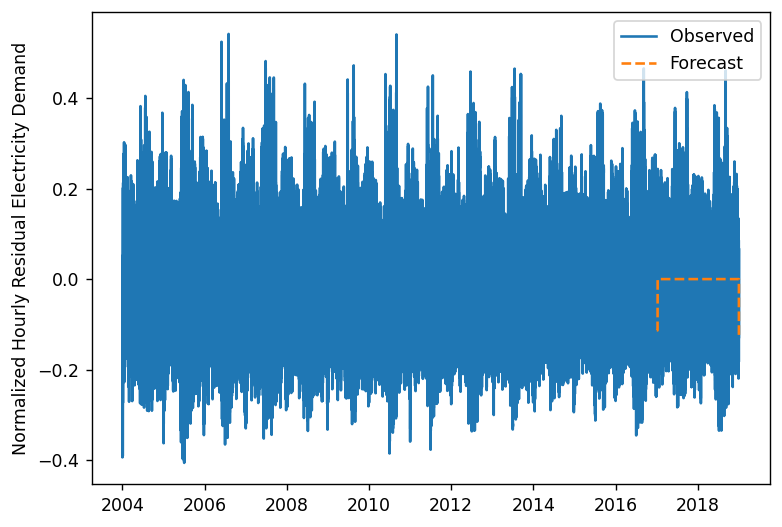

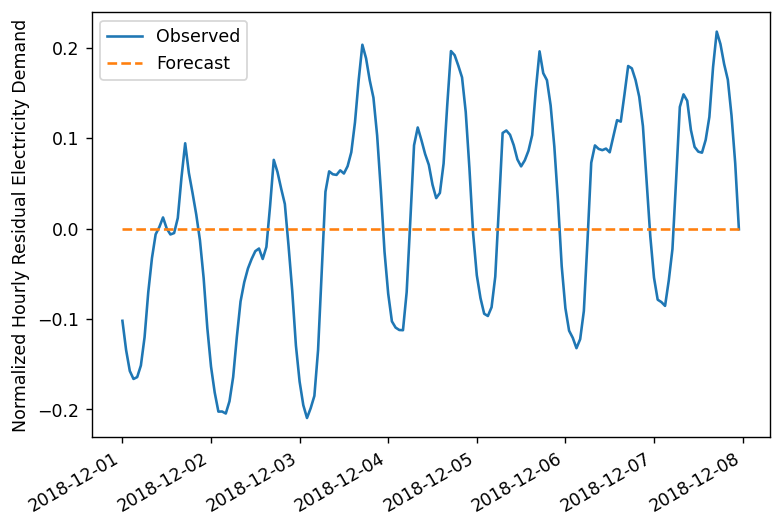

In [ ]:
# get forecast "predictions" from the baseline persistance model
idx = validate.index[::168]
idx = idx.append(pd.DatetimeIndex(['2018-12-31 23']))
pred = pd.Series(np.hstack([y_init_val, yp_val.iloc[-1]]), index=idx)
pred = pred.resample('H').ffill().values

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

## **Linear Regression**

MAE: 1.099039921539281e-16


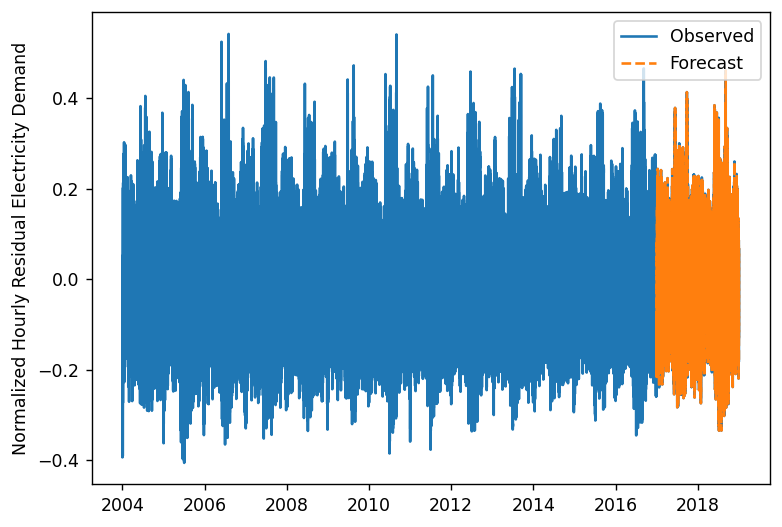

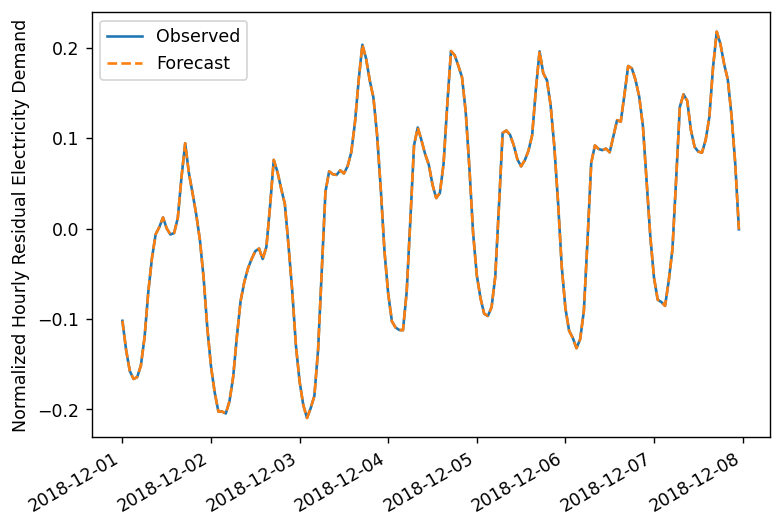

In [ ]:
from sklearn.linear_model import LinearRegression

# train model and get predictions
mod_lr = LinearRegression()
mod_lr.fit(X_tr, y_tr)
pred = weekly_forecast(mod_lr, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

## **Gradient Boosted Regression**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# train GBR model, and get validation set performance
def get_gbr_mae(lr, ne, md):
    mod = GradientBoostingRegressor(learning_rate=lr, n_estimators=ne, max_depth=md)
    mod.fit(X_tr, y_tr)
    pred_val = weekly_forecast(mod, exog_val, y_init_val)
    return compute_mae(y_val, pred_val)

# define potential sets of hyperparameters
learning_rate = [0.01, 0.1, 1.]
n_estimators = [100, 500, 1000]
max_depth = [2, 3, 4]
grid_search = pd.DataFrame(columns=['lr','ne','md','mae'])

# perform grid search
for lr in learning_rate:    
    for ne in n_estimators:        
        for md in max_depth:            
            mae = get_gbr_mae(lr, ne, md)
            params = {'lr':lr, 'ne':ne, 'md':md, 'mae':mae} 
            grid_search = grid_search.append(params, ignore_index=True)

# display best hyperparameters based on grid search
grid_search.sort_values('mae').head(1)

,lr,ne,md,mae
8,0.01,1000.0,4.0,0.000049


MAE: 9.658329620202162e-05


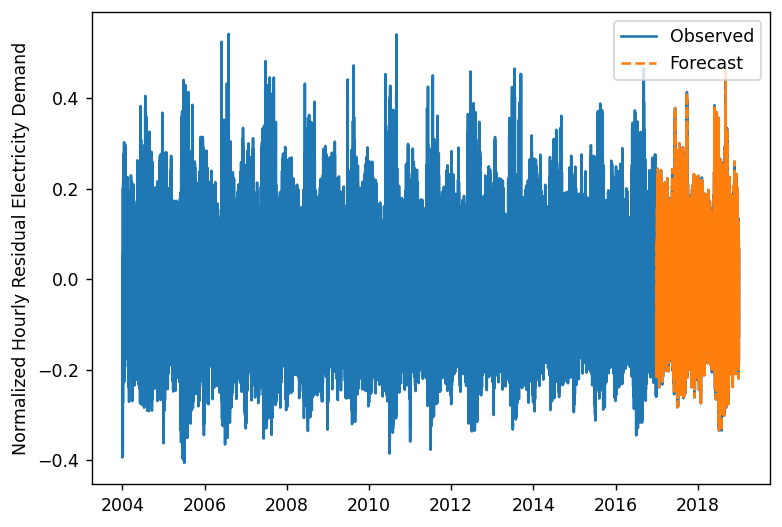

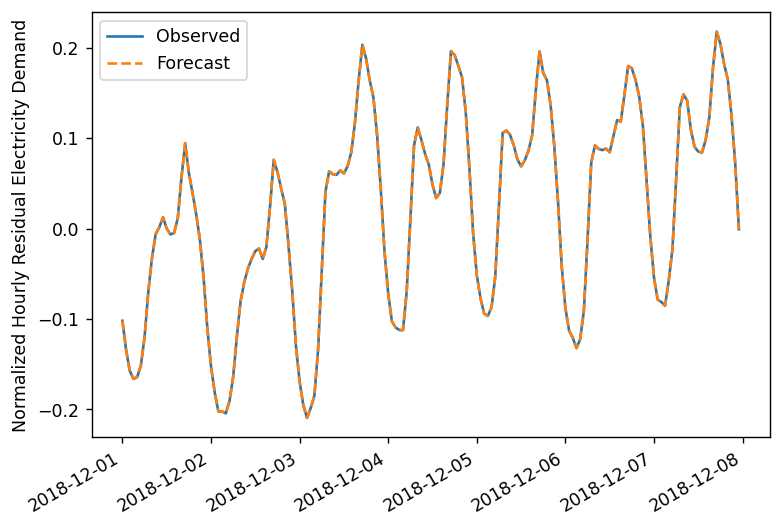

In [ ]:
# best hyperparamters
lr, ne, md = 0.01, 1000, 3

# train model and get predictions
mod_gbr = GradientBoostingRegressor(learning_rate=lr, n_estimators=ne, max_depth=md)
mod_gbr.fit(X_tr, y_tr)
pred = weekly_forecast(mod_gbr, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

## **Multi-Layer Perceptron Regression**

In [ ]:
from sklearn.neural_network import MLPRegressor

# train MLP model, and get validation set performance
def get_mlp_mae(hl, a, lr, mi):
    mod = MLPRegressor(hidden_layer_sizes=hl, alpha=a, learning_rate_init=lr, max_iter=mi)
    mod.fit(X_tr, y_tr)
    pred_val = weekly_forecast(mod, exog_val, y_init_val)
    return compute_mae(y_val, pred_val)

# define potential sets of hyperparameters
hidden_layer_sizes = [(100,),(500,),(100,10,),(100,100,)]
alpha = [0.0001, 0.00001, 0.001]
learning_rate = [0.0001, 0.001, 0.01]
max_iter = [200, 1000, 10000]
grid_search = pd.DataFrame(columns=['hl','a','lr','mi','mae'])

# perform grid search
for hl in hidden_layer_sizes:    
    for a in alpha:        
        for lr in learning_rate:
            for mi in max_iter:
                mae = get_mlp_mae(hl, a, lr, mi)
                params = {'hl':hl, 'a':a, 'lr':lr, 'mi':mi, 'mae':mae} 
                grid_search = grid_search.append(params, ignore_index=True)

# display best hyperparameters based on grid search
grid_search.sort_values('mae').head(1)

,hl,a,lr,mi,mae
26,"(100,)",0.001,0.01,10000,0.000389


MAE: 0.00042691003594481366


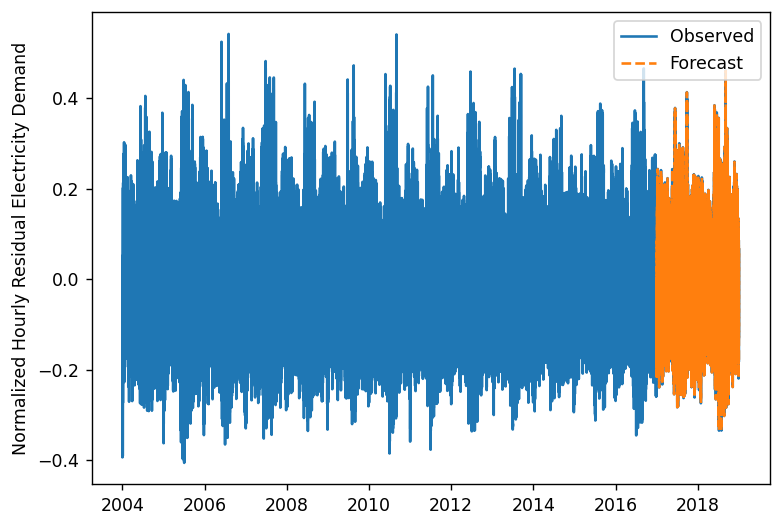

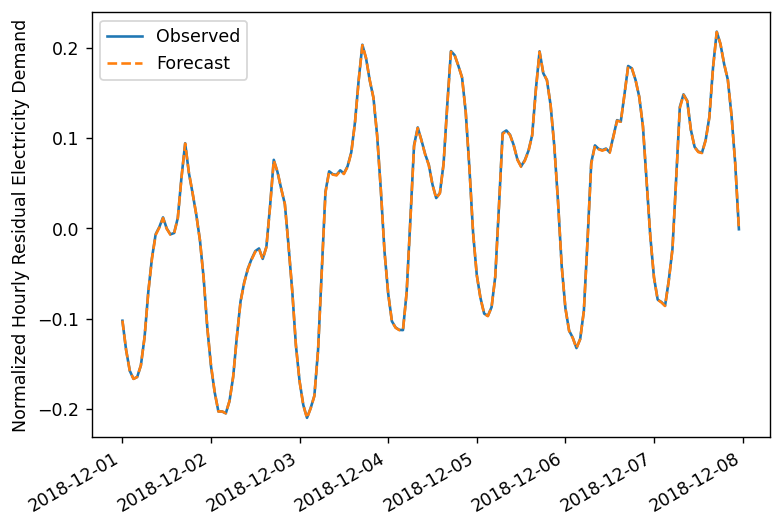

In [ ]:
hl, a, lr, mi  = (500,),	0.001,	0.01,	10000

# train model and get predictions
mod_mlp = MLPRegressor(hidden_layer_sizes=hl, alpha=a, learning_rate_init=lr, max_iter=mi)
mod_mlp.fit(X_tr, y_tr)
pred = weekly_forecast(mod_mlp, exog_val, y_init_val)

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

# **Testing and Evaluating the models**

In [ ]:
# monthly average forecasts
train_m = monthly_norm[:'2018']
test_m = monthly_norm['2019':]
model_m = SARIMAX(train_m, order=best_monthly_order, seasonal_order=best_monthly_seas_order).fit()
forecast_m = model_m.get_forecast(steps=len(test_m))
pred_m_norm = pd.Series(forecast_m.predicted_mean, index=test_m.index)

# baseline hourly residual forecasts
idx = test.index[::168]
idx = idx.append(pd.DatetimeIndex(['2019-12-31 23']))
pred_base = pd.Series(np.hstack([y_init_te, yp_te.iloc[-1]]), index=idx)
pred_base = pred_base.resample('H').ffill().values

# hourly residual forecasts
pred_lr = weekly_forecast(mod_lr, exog_te, y_init_te)
pred_gbr = weekly_forecast(mod_gbr, exog_te, y_init_te)
pred_mlp = weekly_forecast(mod_mlp, exog_te, y_init_te)

In [ ]:
# dataframe of montly forecasts
m_norm_df = pd.DataFrame({'m_norm':pred_m_norm, 'month':pred_m_norm.index.month, 'year':pred_m_norm.index.year})

# baseline: combine monthly/hourly forecasts, unnormalize to original scale
bl_norm_df = pd.DataFrame({'h_norm':pred_base, 'month':test.index.month, 'year':test.index.year})
pred_bl_norm_df = bl_norm_df.merge(m_norm_df, on=['month','year'])
pred_bl_norm = pd.Series((pred_bl_norm_df['m_norm'] + pred_bl_norm_df['h_norm']).values, index=test.index)
pred_bl = pred_bl_norm * (load_max - load_min) + load_min

# linear regression: combine monthly/hourly forecasts, unnormalize to original scale
lr_norm_df = pd.DataFrame({'h_norm':pred_lr, 'month':test.index.month, 'year':test.index.year})
pred_lr_norm_df = lr_norm_df.merge(m_norm_df, on=['month','year'])
pred_lr_norm = pd.Series((pred_lr_norm_df['m_norm'] + pred_lr_norm_df['h_norm']).values, index=test.index)
pred_lr = pred_lr_norm * (load_max - load_min) + load_min

# gradient boosting regression: combine monthly/hourly forecasts, unnormalize to original scale
gbr_norm_df = pd.DataFrame({'h_norm':pred_gbr, 'month':test.index.month, 'year':test.index.year})
pred_gbr_norm_df = gbr_norm_df.merge(m_norm_df, on=['month','year'])
pred_gbr_norm = pd.Series((pred_gbr_norm_df['m_norm'] + pred_gbr_norm_df['h_norm']).values, index=test.index)
pred_gbr = pred_gbr_norm * (load_max - load_min) + load_min

# multi-layer perceptron regression: combine monthly/hourly forecasts, unnormalize to original scale
mlp_norm_df = pd.DataFrame({'h_norm':pred_mlp, 'month':test.index.month, 'year':test.index.year})
pred_mlp_norm_df = mlp_norm_df.merge(m_norm_df, on=['month','year'])
pred_mlp_norm = pd.Series((pred_mlp_norm_df['m_norm'] + pred_mlp_norm_df['h_norm']).values, index=test.index)
pred_mlp = pred_mlp_norm * (load_max - load_min) + load_min

In [ ]:
def compute_mape(y, yhat):
    pct_err = ((yhat - y) / y).dropna()
    return np.mean(np.abs(pct_err)) 

print("baseline MAPE:", compute_mape(df['load'], pred_bl))
print("lin reg MAPE:", compute_mape(df['load'], pred_lr))
print("grad boost reg MAPE:", compute_mape(df['load'], pred_gbr))
print("MLP reg MAPE:", compute_mape(df['load'], pred_mlp))

baseline MAPE: 1.1214015990241308
lin reg MAPE: 0.02693183349904971
grad boost reg MAPE: 0.02693370342356952
MLP reg MAPE: 0.0269021256258905


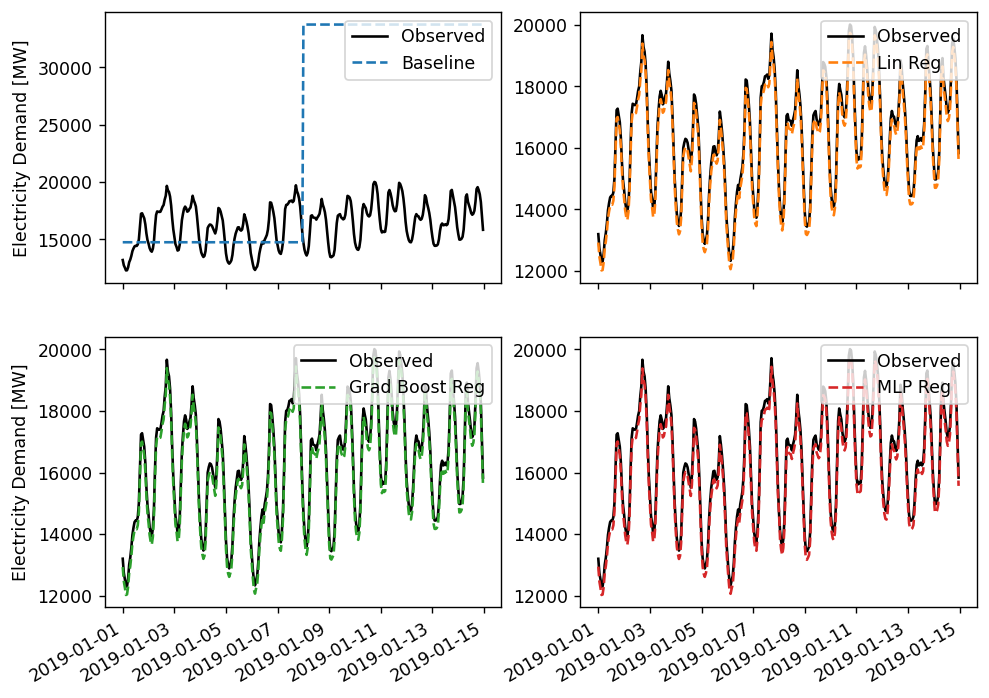

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(9,7))

ax[0,0].plot(df.loc['2019-01-01':'2019-01-14','load'], label='Observed', c='k')
ax[0,0].plot(pred_bl['2019-01-01':'2019-01-14'], label='Baseline', ls='--', c='C0')
ax[0,0].set_ylabel('Electricity Demand [MW]')
ax[0,0].legend(loc=1);

ax[0,1].plot(df.loc['2019-01-01':'2019-01-14','load'], label='Observed', c='k')
ax[0,1].plot(pred_lr['2019-01-01':'2019-01-14'], label='Lin Reg', ls='--', c='C1')
ax[0,1].legend(loc=1);

ax[1,0].plot(df.loc['2019-01-01':'2019-01-14','load'], label='Observed', c='k')
ax[1,0].plot(pred_gbr['2019-01-01':'2019-01-14'], label='Grad Boost Reg', ls='--', c='C2')
ax[1,0].set_ylabel('Electricity Demand [MW]')
ax[1,0].legend(loc=1);

ax[1,1].plot(df.loc['2019-01-01':'2019-01-14','load'], label='Observed', c='k')
ax[1,1].plot(pred_mlp['2019-01-01':'2019-01-14'], label='MLP Reg', ls='--', c='C3')
ax[1,1].legend(loc=1);

fig.autofmt_xdate()

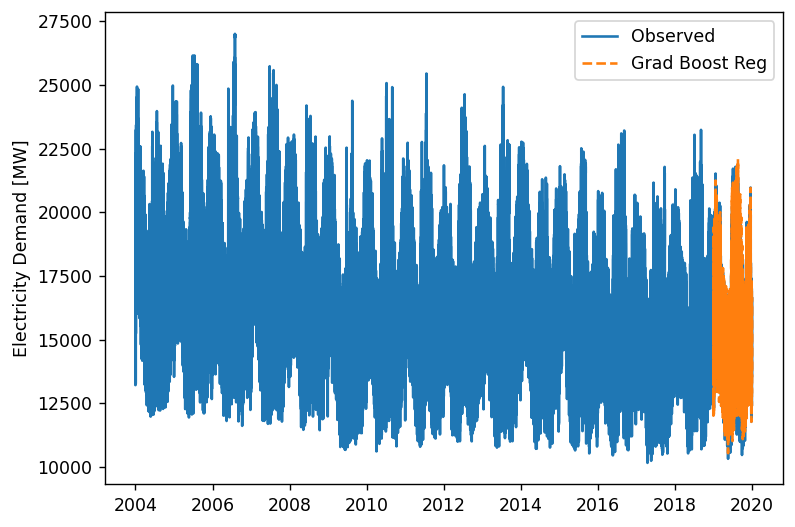

In [ ]:
fig = plt.figure()
plt.plot(df.loc[:,'load'], label='Observed')
plt.plot(pred_gbr, label='Grad Boost Reg', ls='--')
plt.ylabel('Electricity Demand [MW]')
plt.legend();